In [108]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree

from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data loading

In [82]:
# lin_data_path = '../data/CBase de datos_PRESEEA.xlsx'
lin_data_path = '../data/base.csv'
lin_data = pd.read_csv(lin_data_path, sep=',')

In [83]:
remove_cols = [
    'Observaciones especificidad', '...38', '...39', '...40',
    '...41', 'Observaciones', 'Minuto', 'INFORMANTE', 'CONTEXTO',
    'Forma verbal analizada', 'Infinitivo', 'OBLIGATORIO',
    'Referentesujeto', 
]

In [84]:
# Remove columns
lin_data = lin_data.drop(columns=remove_cols)

In [85]:
lin_data.columns

Index(['PRESENCIA', 'Personasujeto', 'Ambfonetica', 'AmbfoneticaN',
       'Ambfoneticaatono', 'Ambfoneticacontextual', 'Especificidad', 'Modo',
       'Tiempoverbal', 'Progresividad', 'Perfectividad', 'Ambmorfologica',
       'ambiguedadmorfologicaatono', 'Ambmorfologicacontext', 'clasesemantica',
       'ADESSE', 'SubtipoADESSE', 'Tipoclausula', 'Correferencialidad',
       'Distanciareferente', 'Turnohabla', 'Perífrasis', 'Pronominal',
       'Tipodiscurso', 'Longitudverbo', 'Edad', 'Sexo', 'Nivel de estudios',
       'CORPUS'],
      dtype='object')

In [86]:
# Check no column have missing values
missing = lin_data.isnull().sum()
missing = missing[missing > 0]
missing

Series([], dtype: int64)

In [87]:
# Check which columns have the highest number of unique values
unique = lin_data.nunique()
unique = unique.sort_values(ascending=False)
unique

SubtipoADESSE                 20
Longitudverbo                 10
clasesemantica                 7
ADESSE                         6
Personasujeto                  6
Tiempoverbal                   5
Distanciareferente             5
Tipoclausula                   4
Tipodiscurso                   4
Modo                           3
Ambfoneticaatono               3
Ambfoneticacontextual          3
AmbfoneticaN                   3
Nivel de estudios              3
Edad                           3
Perífrasis                     3
Ambmorfologicacontext          3
Especificidad                  2
Ambfonetica                    2
PRESENCIA                      2
Progresividad                  2
ambiguedadmorfologicaatono     2
Ambmorfologica                 2
Perfectividad                  2
Correferencialidad             2
Turnohabla                     2
Pronominal                     2
Sexo                           2
CORPUS                         2
dtype: int64

# Data cleaning

In [14]:
col = 'Longitudverbo'
# Remove all 's' in the column and make it int
lin_data[col] = lin_data[col].str.replace('s', '').astype(int)

In [15]:
col = 'Edad'
lin_data[col] = lin_data[col].str.replace('Grupo ', '').astype(int)

In [16]:
col = 'Nivel de estudios'
# Make the column a linear scale, replacing 'Bajo' with 0, 'Medio' with
# 1 and 'Alto' with 2
lin_data[col] = lin_data[col].replace({
    'Bajo': 0,
    'Medio': 1,
    'Alto': 2
})

# lin_data[col] = lin_data[col].str.replace('Grupo ', '').astype(int)

/tmp/ipykernel_7344/1377979243.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lin_data[col] = lin_data[col].replace({


In [17]:
continuous_cols = ['Longitudverbo', 'Edad', 'Nivel de estudios']

In [18]:
lin_data.columns

Index(['Forma verbal analizada', 'Infinitivo', 'PRESENCIA', 'Personasujeto',
       'Referentesujeto', 'Ambfonetica', 'AmbfoneticaN', 'Ambfoneticaatono',
       'Ambfoneticacontextual', 'Especificidad', 'Modo', 'Tiempoverbal',
       'Progresividad', 'Perfectividad', 'Ambmorfologica',
       'ambiguedadmorfologicaatono', 'Ambmorfologicacontext', 'clasesemantica',
       'ADESSE', 'SubtipoADESSE', 'Tipoclausula', 'Correferencialidad',
       'Distanciareferente', 'Turnohabla', 'Perífrasis', 'Pronominal',
       'Tipodiscurso', 'Longitudverbo', 'Edad', 'Sexo', 'Nivel de estudios',
       'CORPUS'],
      dtype='object')

In [19]:
col_idx = 7
col = lin_data.columns[col_idx]
print(f'Analysing column {col}')
lin_data[col].unique()

Analysing column Ambfoneticaatono


array(['Ambiguo', 'No ambiguo', 'Ambiguo pronominal'], dtype=object)

In [20]:
lin_data.head()

,Forma verbal analizada,Infinitivo,PRESENCIA,Personasujeto,Referentesujeto,Ambfonetica,AmbfoneticaN,Ambfoneticaatono,Ambfoneticacontextual,Especificidad,...,Distanciareferente,Turnohabla,Perífrasis,Pronominal,Tipodiscurso,Longitudverbo,Edad,Sexo,Nivel de estudios,CORPUS
0,hablaba,hablar,Expresado,1ª sg,Humano,Ambiguo,Ambiguo,Ambiguo,No ambiguo contextual,Específico,...,Misma oración,Mismo turno,No perífrasis,No pronominal,Narración,3,3,Mujer,0,2015
1,estuve,estar,No expresado,1ª sg,Humano,No ambiguo,No ambiguo,No ambiguo,Ambiguo,Específico,...,Oración anterior,Mismo turno,No perífrasis,No pronominal,Narración,3,3,Mujer,0,2015
2,estuvimos,estar,No expresado,1ª pl,Humano,No ambiguo,No ambiguo,No ambiguo,Ambiguo,Específico,...,Oraciones anteriores,Mismo turno,No perífrasis,No pronominal,Narración,4,3,Mujer,0,2015
3,he estado,estar,Expresado,1ª sg,Humano,No ambiguo,No ambiguo,No ambiguo,Ambiguo,Específico,...,Oración anterior,Mismo turno,No perífrasis,No pronominal,Diálogo,4,3,Mujer,0,2015
4,están,estar,No expresado,3ª pl,Humano,Ambiguo,Ambiguo N,No ambiguo,Ambiguo,Específico,...,Oración anterior,Mismo turno,No perífrasis,No pronominal,Argumentación,2,3,Mujer,0,2015


In [21]:
# Make all columns that are not in continuous_cols categorical
for col in lin_data.columns:
    if col not in continuous_cols:
        lin_data[col] = lin_data[col].astype('category')

In [22]:
# CATEGORY TO CODES
cat_codes = {}
for col in lin_data.columns:
    if col not in continuous_cols:
        codes, uniques = pd.factorize(lin_data[col])
        lin_data[col] = codes
        cat_codes[col] = uniques

In [26]:
# CODES TO CATEGORY (DO NOT RUN)
for col, uniques in cat_codes.items():
    lin_data[col] = lin_data[col].apply(lambda x: uniques[x])

In [23]:
# Calculate percentage of 1 in PRESENCIA
lin_data['PRESENCIA'].value_counts(normalize=True)

PRESENCIA
1    0.772325
0    0.227675
Name: proportion, dtype: float64

# Train

In [114]:
y = lin_data['PRESENCIA']
x = lin_data.drop(columns=['PRESENCIA'])
x = pd.get_dummies(x, drop_first=True)

# x, x_test, y, y_test = train_test_split(x, y, test_size=0.2)

# Train the model
model = DecisionTreeClassifier()
model.fit(x, y)

# Predict the test data
y_pred = model.predict(x)

# Calculate the accuracy
accuracy = accuracy_score(y, y_pred)
print(f'Accuracy: {accuracy}')

# Get the feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

Accuracy: 0.9851971037811745


In [ ]:
# Print the feature ranking
print("Feature ranking:")
for f in range(x.shape[1]):
    print(f"{f + 1}. feature {x.columns[indices[f]]} ({importances[indices[f]]})")

In [ ]:
# Plot the feature importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices], align="center")
plt.xticks(range(x.shape[1]), x.columns[indices], rotation=90)
plt.xlim([-1, x.shape[1]])
plt.show()

## Max depth

In [116]:
model = DecisionTreeClassifier(max_depth=5)
model.fit(x, y)

# Predict the test data
y_pred = model.predict(x)

# Calculate the accuracy
accuracy = accuracy_score(y, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7932421560740145


In [69]:
# Print the nodes that return the highest percentage of 1
node = model.tree_.feature[0]
value = model.tree_.threshold[0]
print(f'Node: {node}, Value: {value}')

# Get the percentage of 1 in the node
node_data = x[x.columns[node]]
node_data = node_data < value
node_data = node_data & y
percentage = node_data.sum() / node_data.shape[0]
print(f'Percentage of 1 in node: {percentage}')

Node: 0, Value: 0.5
Percentage of 1 in node: 0.25679806918744974


In [70]:
n_nodes = model.tree_.node_count
children_left = model.tree_.children_left
children_right = model.tree_.children_right
feature = model.tree_.feature
threshold = model.tree_.threshold
values = model.tree_.value

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node with value={value}.".format(
                space=node_depth[i] * "\t", node=i, value=values[i]
            )
        )
    else:
        print(
            "{space}node={node} is a split node with value={value}: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=x.columns[feature[i]],
                threshold=threshold[i],
                right=children_right[i],
                value=values[i],
            )
        )

The binary tree structure has 57 nodes and has the following tree structure:

node=0 is a split node with value=[[0.22767498 0.77232502]]: go to node 1 if X[:, Personasujeto] <= 0.5 else to node 32.
	node=1 is a split node with value=[[0.36842105 0.63157895]]: go to node 2 if X[:, Distanciareferente] <= 1.5 else to node 17.
		node=2 is a split node with value=[[0.25216638 0.74783362]]: go to node 3 if X[:, Ambfonetica] <= 0.5 else to node 10.
			node=3 is a split node with value=[[0.36293436 0.63706564]]: go to node 4 if X[:, SubtipoADESSE] <= 2.5 else to node 7.
				node=4 is a split node with value=[[0.48113208 0.51886792]]: go to node 5 if X[:, Edad] <= 1.5 else to node 6.
					node=5 is a leaf node with value=[[0.25 0.75]].
					node=6 is a leaf node with value=[[0.56410256 0.43589744]].
				node=7 is a split node with value=[[0.28104575 0.71895425]]: go to node 8 if X[:, Longitudverbo] <= 6.5 else to node 9.
					node=8 is a leaf node with value=[[0.26241135 0.73758865]].
					nod

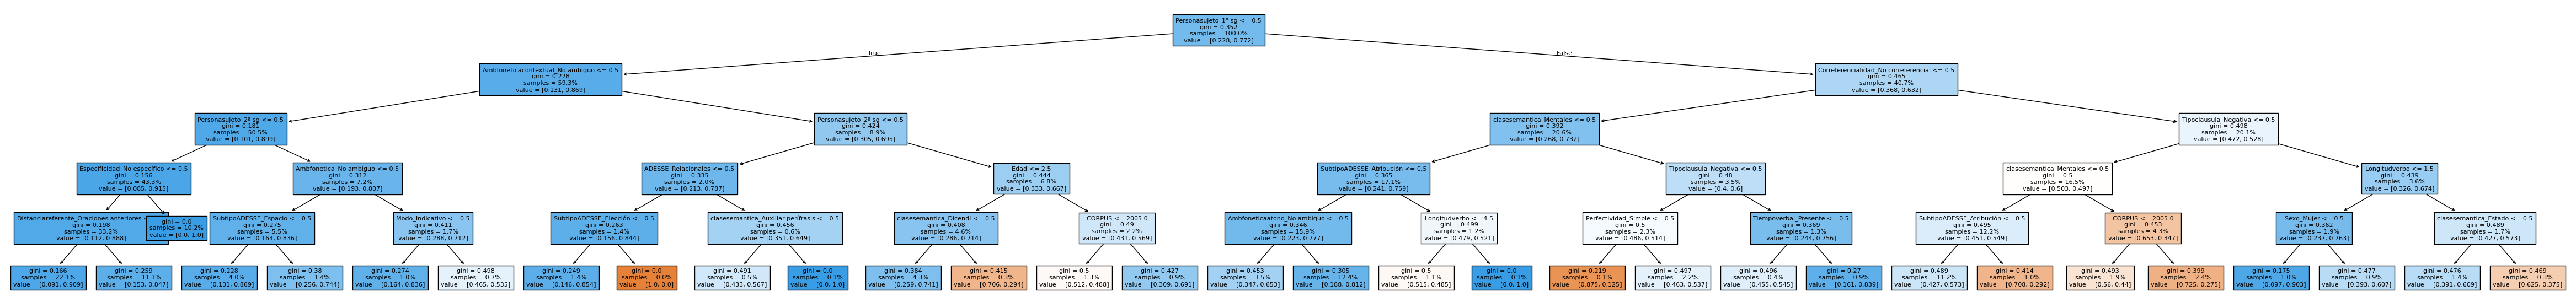

In [117]:
figsize = (60, 7)
fontsize = 8
plt.figure(figsize=figsize)
tree.plot_tree(model, feature_names=x.columns, filled=True, proportion=True,
               fontsize=fontsize)
# plt.show()
plt.savefig('tree.png')

## Remove variables

In [130]:
filter_cols = [
    'Ambfonetica', 'AmbfoneticaN', 'Ambfoneticaatono', 
    'SubtipoADESSE', 'Longitudverbo', 'Tipoclausula',
    'Perfectividad', 'Modo', 'Pronominal', 'Progresividad',
    'Ambmorfologica', 'ambiguedadmorfologicaatono', 'clasesemantica',
    'Distanciareferente', 'Nivel de estudios', 'Edad', 'Sexo', 'CORPUS',
]
# Drop filter columns
lin_data_filtered = lin_data.drop(columns=filter_cols)

In [131]:
lin_data_filtered.columns

Index(['PRESENCIA', 'Personasujeto', 'Ambfoneticacontextual', 'Especificidad',
       'Tiempoverbal', 'Ambmorfologicacontext', 'ADESSE', 'Correferencialidad',
       'Turnohabla', 'Perífrasis', 'Tipodiscurso'],
      dtype='object')

In [125]:
len(lin_data)

6215

In [132]:
model = DecisionTreeClassifier(min_samples_split=int(len(lin_data) * 0.03))
y = lin_data_filtered['PRESENCIA']
x = lin_data_filtered.drop(columns=['PRESENCIA'])
x = pd.get_dummies(x, drop_first=True)
model.fit(x, y)

# Predict the test data
y_pred = model.predict(x)

# Calculate the accuracy
accuracy = accuracy_score(y, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7864843121480289


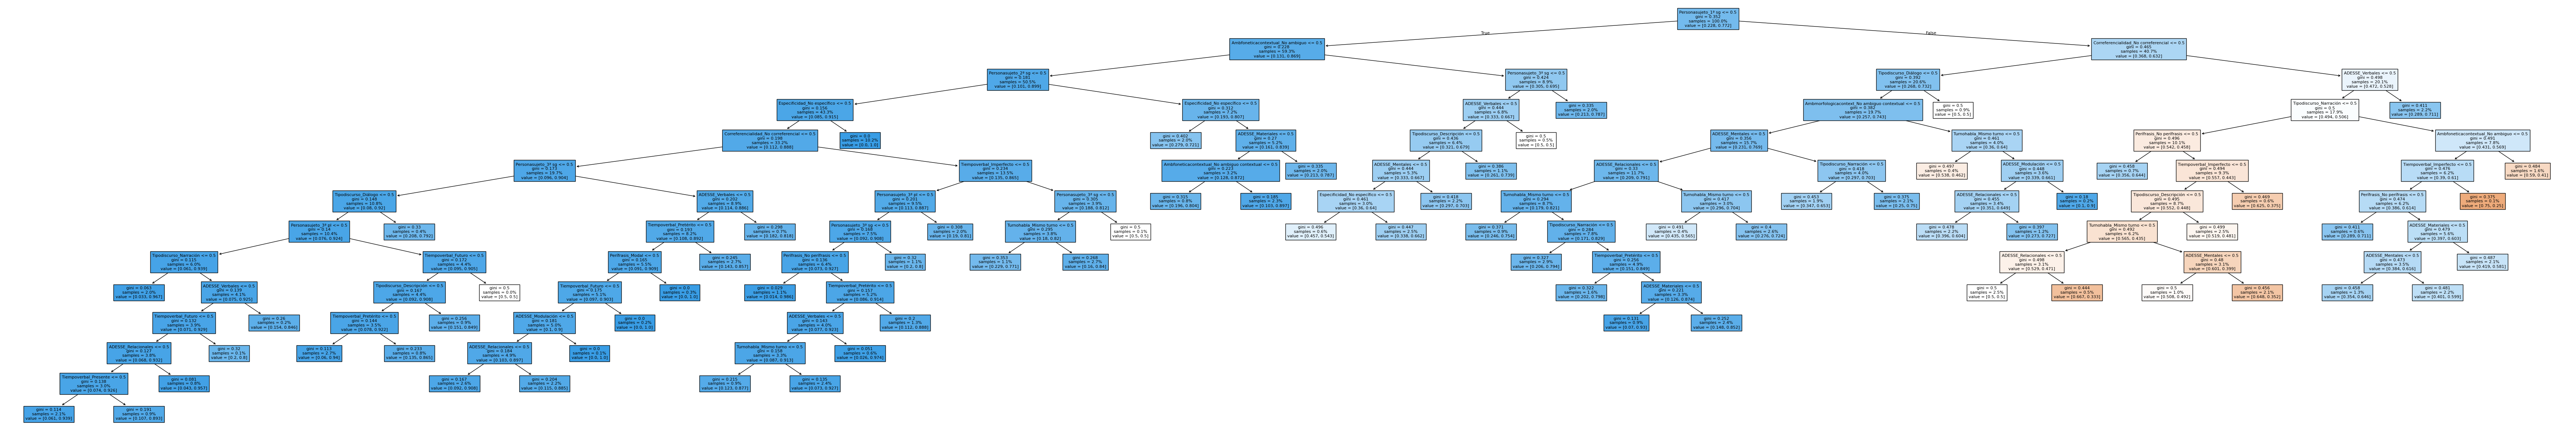

In [139]:
figsize = (90, 15)
fontsize = 8
plt.figure(figsize=figsize)
tree.plot_tree(model, feature_names=x.columns, filled=True, proportion=True,
               fontsize=fontsize)
# plt.show()
plt.savefig('tree_filtered.png', dpi=300)

# Brute force

In [91]:
def combine_n_columns(df, depth):
    '''
    Create all possible combinations without repetition of n columns

    Returns a list of dictionaries with the structure:
    {'col_1': value_1, 'col_2': value_2, ..., 'col_n': value_n}
    '''

    if depth == 1:
        all_list = []
        for col in df.columns:
            for value in df[col].unique():
                # If value is a numpy type, convert it to a python type
                if isinstance(value, np.generic):
                    value = value.item()
                all_list.append({col: value})
        return all_list
    else:
        all_list = []
        for col in df.columns:
            for value in df[col].unique():
                # If value is a numpy type, convert it to a python type
                if isinstance(value, np.generic):
                    value = value.item()
                for sub_dict in combine_n_columns(df.drop(columns=[col]), depth - 1):
                    sub_dict[col] = value
                    all_list.append(sub_dict)
        return all_list

    


In [103]:
combinations = combine_n_columns(lin_data.drop(columns=['PRESENCIA']), 3)

In [104]:
len(combinations)

1186170

In [105]:
p_df = pd.DataFrame(combinations)

In [112]:
combinations[0]

{'AmbfoneticaN': 'Ambiguo', 'Ambfonetica': 'Ambiguo', 'Personasujeto': '1ª sg'}

In [117]:
for condition in combinations[0].items():
    print(condition)

('AmbfoneticaN', 'Ambiguo')
('Ambfonetica', 'Ambiguo')
('Personasujeto', '1ª sg')


In [122]:
# Remap the PRESENCIA column to 0 and 1
lin_data['PRESENCIA'] = lin_data['PRESENCIA'].replace({
    'No expresado': 0,
    'Expresado': 1
})

/tmp/ipykernel_7344/687984336.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lin_data['PRESENCIA'] = lin_data['PRESENCIA'].replace({


In [124]:
sub_df['PRESENCIA'].sum() / sub_df.shape[0]

np.float64(0.22767497988736926)

In [129]:
p_df

,AmbfoneticaN,Ambfonetica,Personasujeto,Ambfoneticaatono,Ambfoneticacontextual,Especificidad,Modo,Tiempoverbal,Progresividad,Perfectividad,...,Turnohabla,Perífrasis,Pronominal,Tipodiscurso,Longitudverbo,Edad,Sexo,Nivel de estudios,CORPUS,percentage
0,Ambiguo,Ambiguo,1ª sg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.446389
1,No ambiguo,Ambiguo,1ª sg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000
2,Ambiguo N,Ambiguo,1ª sg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000
3,NaN,Ambiguo,1ª sg,Ambiguo,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.450704
4,NaN,Ambiguo,1ª sg,No ambiguo,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1186165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Grupo 3,NaN,Alto,1995.0,-1.000000
1186166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Grupo 1,NaN,Alto,1995.0,-1.000000
1186167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Grupo 2,NaN,Alto,1995.0,-1.000000
1186168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Mujer,Alto,1995.0,-1.000000


In [130]:
# Calculate the percentage of 1 in column PRESENCIA for each combination, only if the number of samples is greater than 100
p_df['presence'] = -1
p_df['samples'] = -1
for i, condition in tqdm(enumerate(combinations), total=len(combinations)):
    sub_df = lin_data
    for condition in condition.items():
        sub_df = sub_df[sub_df[condition[0]] == condition[1]]
    if sub_df.shape[0] > 100:
        p_df.loc[i, 'presence'] = sub_df['PRESENCIA'].sum() / sub_df.shape[0]
        p_df.loc[i, 'samples'] = sub_df.shape[0]

  0%|          | 0/1186170 [00:00<?, ?it/s]/tmp/ipykernel_7344/2211236201.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.44638949671772427' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  p_df.loc[i, 'presence'] = sub_df['PRESENCIA'].sum() / sub_df.shape[0]
100%|██████████| 1186170/1186170 [21:57<00:00, 900.51it/s] 


In [141]:
p_df = pd.read_csv('combinations.csv')

In [142]:
# Remove all rows with -1 in the samples column
p_df = p_df[p_df['samples'] != -1]

In [143]:
# Sort the dataframe by the presence column
p_df = p_df.sort_values('presence', ascending=False)

In [144]:
# Remove all rows with presence higher than 0.1 and lower than 0.5
p_df = p_df[(p_df['presence'] < 0.1) | (p_df['presence'] > 0.5)]

In [146]:
p_df = p_df.drop(columns=['percentage'])

In [ ]:
final_df = pd.DataFrame(columns=['feature_1', 'value_1', 'feature_2', 'value_2', 'feature_3', 'value_3', 'presence', 'samples'])

for i, row in p_df.iterrows():
    # Remove all columns with NaN
    row = row.dropna()
    new_row = pd.Series(index=final_df.columns)
    for i, (feature, value) in enumerate(row.items()):
        if i == 3:
            break
        new_row[f'feature_{i + 1}'] = feature
        new_row[f'value_{i + 1}'] = value
    new_row['presence'] = row['presence']
    new_row['samples'] = row['samples']

    # Append the new row to the final dataframe
    final_df.loc[final_df.shape[0]] = new_row

In [173]:
final_df

,feature_1,value_1,feature_2,value_2,feature_3,value_3,presence,samples
0,Ambfonetica,No ambiguo,SubtipoADESSE,Cognición,Longitudverbo,2s,0.725,120
1,AmbfoneticaN,No ambiguo,SubtipoADESSE,Cognición,Longitudverbo,2s,0.725,120
2,Ambfonetica,No ambiguo,SubtipoADESSE,Cognición,Longitudverbo,2s,0.725,120
3,AmbfoneticaN,No ambiguo,SubtipoADESSE,Cognición,Longitudverbo,2s,0.725,120
4,AmbfoneticaN,No ambiguo,SubtipoADESSE,Cognición,Longitudverbo,2s,0.725,120
...,...,...,...,...,...,...,...,...
19927,AmbfoneticaN,Ambiguo N,Especificidad,No específico,Correferencialidad,Correferencial,0.0,178
19928,Personasujeto,3ª pl,Especificidad,No específico,Correferencialidad,Correferencial,0.0,200
19929,AmbfoneticaN,Ambiguo N,Especificidad,No específico,Sexo,Hombre,0.0,262
19930,AmbfoneticaN,Ambiguo N,Especificidad,No específico,Turnohabla,Mismo turno,0.0,382


In [177]:
# Save the final dataframe to a csv file
final_df.to_csv('final_df.csv', index=False)

In [175]:
# Remove duplicate rows
final_df = final_df.drop_duplicates()

In [176]:
final_df

,feature_1,value_1,feature_2,value_2,feature_3,value_3,presence,samples
0,Ambfonetica,No ambiguo,SubtipoADESSE,Cognición,Longitudverbo,2s,0.725,120
1,AmbfoneticaN,No ambiguo,SubtipoADESSE,Cognición,Longitudverbo,2s,0.725,120
12,Personasujeto,1ª sg,SubtipoADESSE,Cognición,Longitudverbo,2s,0.719008,121
18,Ambfoneticaatono,No ambiguo,SubtipoADESSE,Cognición,Longitudverbo,2s,0.701613,124
20,Ambfoneticacontextual,Ambiguo,SubtipoADESSE,Cognición,Longitudverbo,2s,0.701613,124
...,...,...,...,...,...,...,...,...
19580,AmbfoneticaN,Ambiguo N,Especificidad,No específico,Edad,Grupo 1,0.0,176
19595,AmbfoneticaN,Ambiguo N,Especificidad,No específico,Distanciareferente,No aparece,0.0,103
19597,AmbfoneticaN,Ambiguo N,Especificidad,No específico,Progresividad,No progresivo,0.0,445
19627,AmbfoneticaN,Ambiguo N,Especificidad,No específico,Ambmorfologica,No ambiguo,0.0,476
